# Introduction

In this project, we consider the following dataset with information about diabetes patients admitted to 130 hospitals in the US. 

> Clore, J., Cios, K., DeShazo, J., & Strack, B. (2014). Diabetes 130-US Hospitals for Years 1999-2008 [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5230J.

The data set was compiled as part of a research project that aimed to predict whether patients would be readmitted to hospitals after being discharged. We will attempt the same prediction task, but our main goal is to illustrate how two unsupervised learning techniques, $k$-means clustering and principal component analysis, can reduce the dimensionality of the dataset used for prediction, thereby increasing efficiency, while also maintaining precision and accuracy. 

The following cell imports the libraries and functions that we will need as well as the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
top_dir = "https://raw.githubusercontent.com/mattjanko/"
filename = "diabetes-readmission/refs/heads/main/diabetic_data.csv"
data = pd.read_csv(top_dir + filename)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Data cleaning

Each row of the dataset contains information about the admission of a patient to a hospital. The first two columns are identifiers for the admission and the patient admitted. The first identifier is just an extra index and can be dropped. The second identifier is obviously related to hospital readmission since any patient identifier that appears more than once belongs to a patient that was readmitted. Since the prediction task involves readmission, we need to drop the patient identifier column.

In [2]:
df = df.drop(["encounter_id", "patient_nbr"], axis = 1)

In the next cell, we compute the fraction of missing values in columns with NAs.

In [3]:
for c in df.columns:
    na_rate = df[c].isna().mean()
    if na_rate > 0:
        print(f"column = {c}, missing value rate = {np.round(na_rate, 2)}")

column = max_glu_serum, missing value rate = 0.95
column = A1Cresult, missing value rate = 0.83


Only a couple columns have missing values, and in those columns, values are missing at a rate of more than 80%. With so many values missing, there is no reason to leave these columns in the dataset.

In [4]:
df = df.drop(["max_glu_serum", "A1Cresult"], axis = 1)

A quick scan of some of the other columns reveals that there are missing values in other columns that have been coded with the string `"?"`. In the next cell, we compute the fraction of question mark values in each column.

In [5]:
for c in df.columns:
    qm_rate = (df[c] == "?").mean()
    if qm_rate > 0:
        print(f"column = {c}, missing value rate = {np.round(qm_rate, 2)}")

column = race, missing value rate = 0.02
column = weight, missing value rate = 0.97
column = payer_code, missing value rate = 0.4
column = medical_specialty, missing value rate = 0.49
column = diag_1, missing value rate = 0.0
column = diag_2, missing value rate = 0.0
column = diag_3, missing value rate = 0.01


In cases where the fraction of question marks is low, we can simply drop the rows with missing values and preserve the rest of the column. In the other cases, there are too many missing values to interpolate values in a reliable way, so we drop the columns.

In [6]:
df = df.drop(["weight", "payer_code", "medical_specialty"], axis = 1)
df = df.drop(df[df["race"] == "?"].index)
df = df.drop(df[df["diag_1"] == "?"].index)
df = df.drop(df[df["diag_2"] == "?"].index)
df = df.drop(df[df["diag_3"] == "?"].index)

The `gender` column turns out to have a missing value coded as `"Unknown/Invalid"`. The corresponding row can be dropped.

In [7]:
df["gender"].value_counts()

gender
Female             52833
Male               45219
Unknown/Invalid        1
Name: count, dtype: int64

In [8]:
df = df.drop(df[df["gender"] == "Unknown/Invalid"].index)

Ages are coded with strings representing age ranges like `"[20,30)"`, `"[30,40)"`, and so forth. We can translate each string into an integer representing the midpoint of the corresponding range (25 to represent "[20,30)", 35 to represent "[30,40)", and so forth).

In [9]:
df["age"].value_counts()

age
[70-80)     25305
[60-70)     21809
[80-90)     16702
[50-60)     16697
[40-50)      9265
[30-40)      3548
[90-100)     2717
[20-30)      1478
[10-20)       466
[0-10)         65
Name: count, dtype: int64

In [10]:
df["age"] = df["age"].str.slice(1,2).astype(int)*10 + 5
df["age"].value_counts()

age
75    25305
65    21809
85    16702
55    16697
45     9265
35     3548
95     2717
25     1478
15      466
5        65
Name: count, dtype: int64

# Exploratory data analysis

There are nine features that are essentially numerical: `age`, `time_in_hospital`, and seven other features counting various events in patients medical files. Below are summary statistics for these features and a heatmap of their correlation matrix.

In [11]:
corr_features = [
    "time_in_hospital", "num_lab_procedures", "num_procedures", 
    "num_medications", "number_outpatient", "number_emergency",
    "number_inpatient", "number_diagnoses", "age"
]
df[corr_features].describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,age
count,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000
mean,4.422011,43.148462,1.350712,16.119590,0.376382,0.202464,0.646871,7.512096,66.260250
std,2.993070,19.711757,1.708475,8.108496,1.283365,0.942897,1.271025,1.832472,15.590805
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,5.000000
25%,2.000000,31.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000,55.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,65.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,75.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000,95.000000


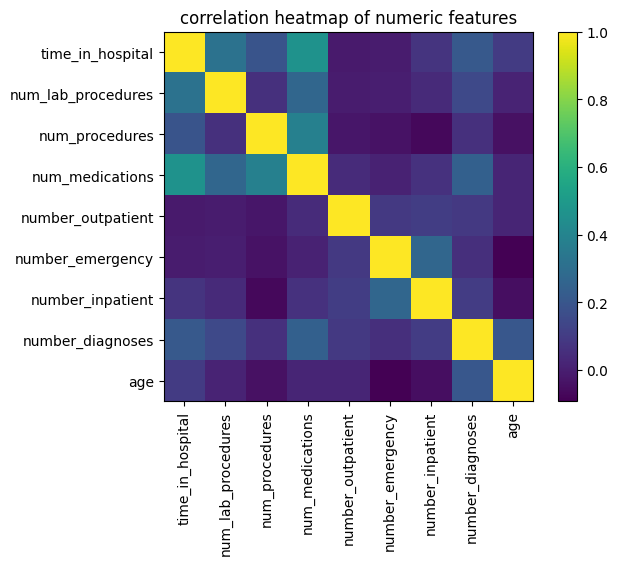

In [12]:
fig, ax = plt.subplots()
im = plt.imshow(df[corr_features].corr())
plt.colorbar()
ax.set_xticks(
    range(len(corr_features)),
    labels = corr_features,
    rotation = 90
)
ax.set_yticks(
    range(len(corr_features)),
    labels = corr_features
)
ax.set_title("correlation heatmap of numeric features")
plt.show()

In [13]:
max_corr = np.corrcoef(df["time_in_hospital"], df["num_medications"])
print("max correlation:", max_corr[0,1])

max correlation: 0.4642121794186633


The heatmap shows no evidence of strong correlations among the numerical features (the maximum correlation coefficient was approximately 0.46). However, the summary statistics show evidence of very skewed distributions in the `number_outpatient`, `number_emergency`, and `number_inpatient` features. The following cell shows the distribution of values in `number_inpatient`.

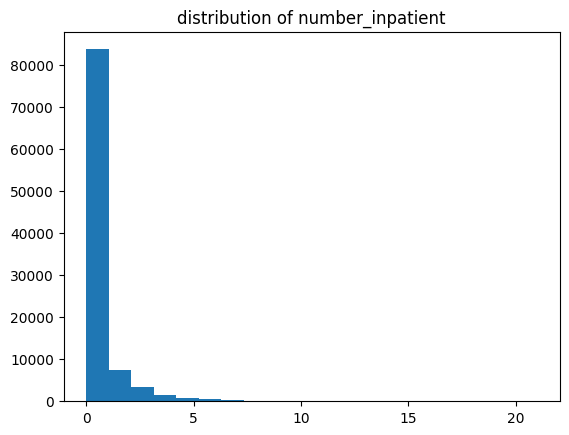

In [14]:
plt.hist(df["number_inpatient"], bins = 20)
plt.title("distribution of number_inpatient")
plt.show()

The distribution of `number_inpatient` appears to be approximately exponential, which is what we might expect to see. The distributions of `number_outpatient` and `number_emergency` are similar.

The following cells show visualizations of the distribution of patients by age, gender, and race.

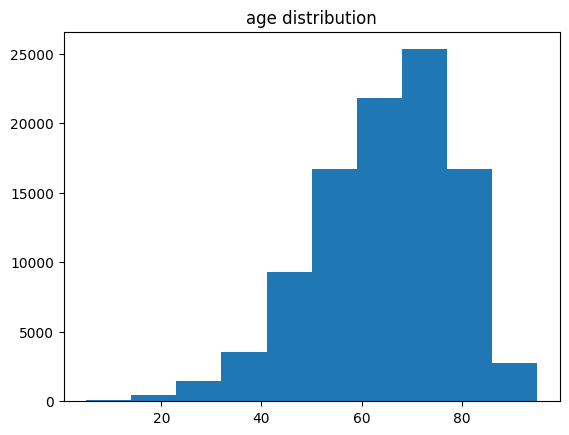

In [15]:
plt.hist(df["age"])
plt.title("age distribution")
plt.show()

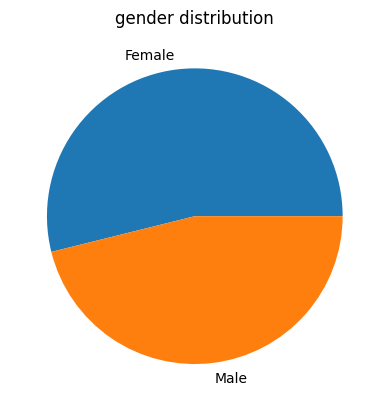

In [16]:
genders = df["gender"].value_counts()
plt.pie(genders, labels = genders.index)
plt.title("gender distribution")
plt.show()

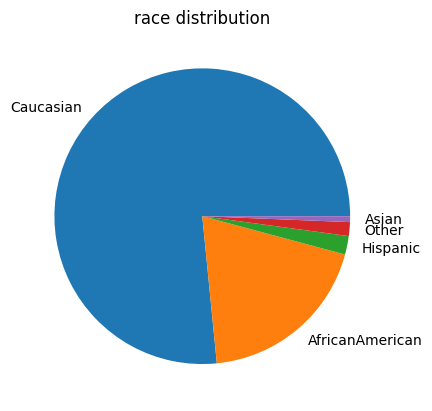

In [17]:
races = df["race"].value_counts()
plt.pie(races, labels = races.index)
plt.title("race distribution")
plt.show()

Age appears to have an approximately normal distribution, and the numbers of male and female patients are approximately equal. However, there are far more Caucasian patients represented in the data than any other racial group. If hospital readmission is closely related to race, then this imbalanced representation might lead to bias in our model. In the next cell, we compute the readmission rate for each ratial group.

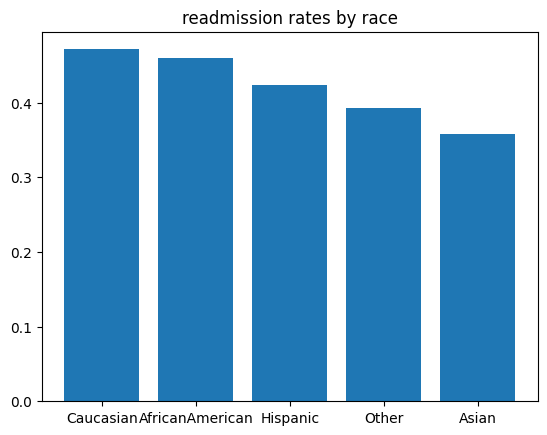

In [18]:
readmit_by_race = [(
    df[df["race"] == r]["readmitted"] != "NO"
).mean() for r in races.index]
plt.bar(races.index, readmit_by_race)
plt.title("readmission rates by race")
plt.show()

There is no obvious relationshp between race and readmission, so we will not take any special measures to address the imbalance in the data set.

One final aspect of the data we wish to investigate is relationships among medicastions perscribed. In the following cell, we assign 1s and 0s to each patient for each medication recorded in the dataset according to whether or not they are prescribed the medication. We then create a heatmap of the correlation matrix for these binary columns.

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


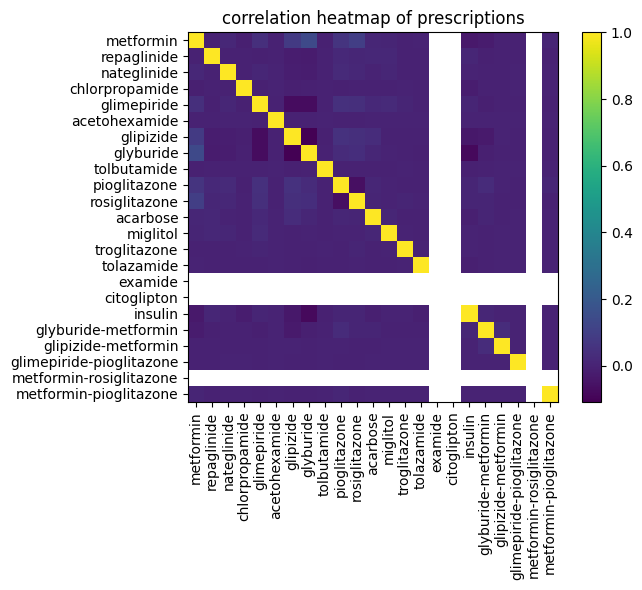

In [19]:
medications = [
    "metformin", "repaglinide", "nateglinide", "chlorpropamide",
    "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
    "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
    "tolazamide", "examide", "citoglipton", "insulin", "glyburide-metformin", 
    "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone",
    "metformin-pioglitazone"
]
meds_dict = {
    m : 1*(df[m] != "No") for m in medications
}
meds_df = pd.DataFrame(meds_dict)
fig, ax = plt.subplots()
im = plt.imshow(meds_df.corr())
plt.colorbar()
ax.set_xticks(
    range(len(medications)),
    labels = medications,
    rotation = 90
)
ax.set_yticks(
    range(len(medications)),
    labels = medications
)
ax.set_title("correlation heatmap of prescriptions")
plt.show()

Looking at the heatmap, we see that there are no significant correlations among prescriptions. Helpfully, we also see that examide, citoglipton, and metformin-rosiglitazone are not prescribed to any patient in the dataset, so these columns can be dropped.

In [20]:
df = df.drop(["examide", "citoglipton", "metformin-rosiglitazone"], axis = 1)

# Data preprocessing
The entries in many of the remaining columns are almost entirely strings that should be encoded as integers. For instance, gender can be encoded with binary integers.

In [21]:
df["gender"] = 1*(df["gender"] == "Female")

Each of the columns representing medications is coded the same way: entries of `"No"` are recorded for patients who are not prescribed the medication, and entries of `"Steady"`, `"Up"`, and `"Down"` are recorded for patients whose prescriptions stayed the same, increased, and decreased during the hospitalization. A more semantically meaningful way to encode this information is as a pair of values `prescribed` and `change` for each medication, in which `prescribed` is a boolean indicating whether the medication was prescribed and `change` is 0, 1, or -1 depending on whether the prescription stayed the same, increased, or decreased.

In [22]:
medications = [
    "metformin", "repaglinide", "nateglinide", "chlorpropamide",
    "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
    "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
    "tolazamide",                          "insulin", "glyburide-metformin", 
    "glipizide-metformin", "glimepiride-pioglitazone", 
    "metformin-pioglitazone"
]
for m in medications:
    df[f"{m}.prescribed"] = (df[m] != "No")
    df[f"{m}.change"] = 1*(df[m] == "Up") - 1*(df[m] == "Down")
    df = df.drop(m, axis = 1)

In the `diabetesMed` column, the value `"Yes"` is recorded whenever a patient is prescribed a diabetes medication, and in the `change`, the value `"Ch"` is recorded whenever there was a change in the patient's diabetes medication during the hospitalization. These can be changed to booleans. In the `readmitted` column, values of `"No"`, `"<30"`, and `">30"` are recorded to indicate patients who were not readmitted or who were readmitted in less than or more than 30 days. These can be coded as 0, 1, and 2.

In [23]:
df["diabetesMed"] = df["diabetesMed"] == "Yes"
df["change"] = (df["change"] == "Ch")
df["readmitted"] = 1*(df["readmitted"] == "<30") + 2*(df["readmitted"] == ">30")

The remaining columns with strings are `race`, `diag_1`, `diag_2`, and `diag_3`. These columns represent categorical variables (`diag` here means diagnosis) and need to be one-hot encoded. Additionally, the columns `admission_type_id`, `discharge_disposition_id`, and `admission_source_id` are categorical (though they are coded with integers) and also need to be one-hot encoded.

In [24]:
oh_encoder = OneHotEncoder(sparse_output = False)
oh_vars = [
    "race", "admission_type_id", "discharge_disposition_id", 
    "admission_source_id", "diag_1", "diag_2", "diag_3"
]
oh_df = pd.DataFrame(oh_encoder.fit_transform(df[oh_vars])).astype(int)
oh_df.index = df.index
oh_df.columns = oh_encoder.get_feature_names_out(oh_vars)
df = pd.concat([df, oh_df], axis = 1)
df = df.drop(oh_vars, axis = 1)

As a final check that the data is clean, we check that there are no columns with `dtype = "object"`. We also check the dimensions of our new dataset.

In [25]:
obj_cols = [c for c in df.columns if df.dtypes[c] == "object"]
print(f"num of object cols = {len(obj_cols)}")
print(f"dimensions of df = {df.shape}")

num of object cols = 0
dimensions of df = (98052, 2348)


The fact that there are no `"object"` columns indicates that all the strings in the original dataset have been reencoded numerically. Our data is now formated appropriately for prediction. Unfortunately, there are now 2347 features in our data, largely due to one-hot encoding all the `diag` columns, and this large number of columns will decrease the efficiency of fitting a model in just about any machine learning approach. This inefficiency motivates our interest in dimensionality reduction using unsupervised learning techniques.

# Data partitioning and inital training

The target variable is `readmitted`, which is now coded with the values 0, 1, and 2 to represent hospital admissions of patients who were subsequently not readmitted, readmitted within 30 days, and readmitted after more than 30 days. Before setting up a predictor, we should consider the distribution of 0s, 1s, and 2s in our data.

readmitted
0    0.533768
2    0.353374
1    0.112858
Name: count, dtype: float64


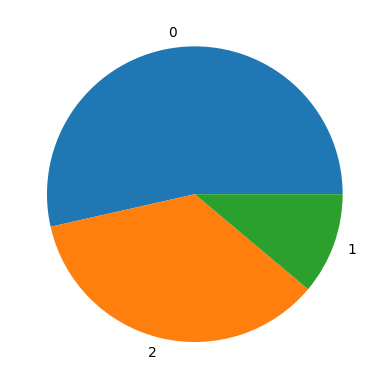

In [26]:
counts_by_value = df["readmitted"].value_counts()/df.shape[0]
plt.pie(np.round(counts_by_value.values, 2), labels = counts_by_value.index)
print(counts_by_value)

Currently, the dataset is rather imbalanced. The underrepresentation of 1s and 2s in the `readmitted` column will tend to bias models toward predicting 0. If we were primarily interested in three-way prediction performance, there are various ways to address the imbalance, including

* restricting the training/test split to a balanced subset of the data,
* oversampling the minority classes in the training/test split, or
* applying class weights to penalize minority-class misclassifications more heavily.

In this context, we care more about demonstrating dimensionality reduction using unsupervised learning techniques, so we can also consider reformulating the classification task. In the next cell, we combine the two minority classes into a single class, leading to a binary classification problem about predicting whether patients will be readmitted to a hospital using well-balanced data.

In [27]:
df["readmitted"] = df["readmitted"] > 0

We now partition the now-balanced dataset into a training/test split.

In [28]:
X = df.copy()
y = X.pop("readmitted")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 208)

To establish a baseline performance level, we will now fit a prediction model using all 2347 features. Because we are starting with such high-dimensional data, we will use the fairly efficient `XGBClassifier` as our model. The following block initiates the model, fits on the training data, and predicts on the test data. We measure model performance on two metrics: precision and accuracy. Precision is a reasonable metric when one is particularly sensitive to false positives (e.g., if one were trying to allocate limited hospital resources for follow-up care). Accuracy is generally a reasonable metric whenever a classifier is used with balanced data. The accuracy and precision scores of our full-dimensional model are shown below along with a confusion matrix.

total features = 2347
precision = 0.64, accuracy = 0.65
confusion matrix:


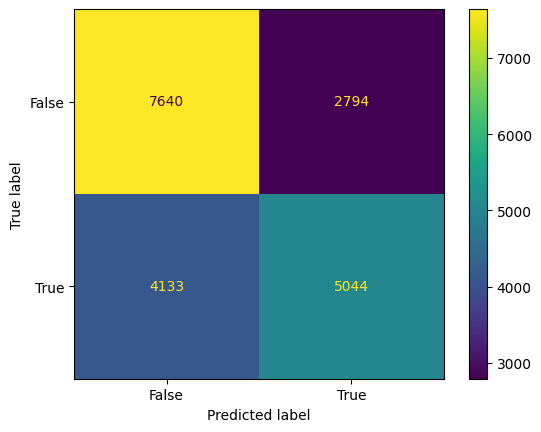

In [29]:
model = XGBClassifier(random_state = 208)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
p = precision_score(y_test, y_pred)
a = accuracy_score(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(f"total features = {len(X_train.columns)}")
print(f"precision = {np.round(p, 2)}, accuracy = {np.round(a, 2)}")
print("confusion matrix:")

The precision and accuracy of our intial model are somewhat better than a random classifier. In a supervised learning context, we would wish to raise these metrics if possible, but our purpose is dimension reduction through unsupervised learning. In the next section, we use $k$-means clustering and principal component analysis to produce a model with similar precision and accuracy on a training set with fewer columns.

# Unsupervised feature engineering

Broadly speaking, our original dataset had five categories of features:

1. demographic features (`race`, `age`, and `gender`),
2. numerical features describing hospital stays (`time_in_hospital`, `num_lab_procedures`, etc.),
3. medication features (`diabedtesMed`, `metformin`, etc.),
4. "in/out" features (`admission_type_id`, `discharge_disposition_id`, etc.), and
5. diagnostic features (`diag_1`, `diag_2`, and `diag_3`).

After data cleaning, these five categories of features remain, although most of them have undergone some form of reencoding. In the following cells, we gather the column names of the reencoded variables in each category.

In [30]:
demo_features = [c for c in df.columns if c[0:5] == "race_"] + ["age", "gender"]
num_features = [
    "time_in_hospital", "num_lab_procedures", "num_procedures", 
    "num_medications", "number_outpatient", "number_emergency",
    "number_inpatient", "number_diagnoses"
]
med_features = (
    ["change", "diabetesMed"] + 
    [f"{m}.prescribed" for m in medications] +
    [f"{m}.change" for m in medications]
)
io_features = [c for c in df.columns if c[0:9] in ["admission", "discharge"]]
diag_features = [c for c in df.columns if c[0:4] == "diag"]
print(f"number of demographic features: {len(demo_features)}")
print(f"number of numerical features: {len(num_features)}")
print(f"number of medication features: {len(med_features)}")
print(f"number of in/out features: {len(io_features)}")
print(f"number of diagnosis features: {len(diag_features)}")

number of demographic features: 7
number of numerical features: 8
number of medication features: 42
number of in/out features: 51
number of diagnosis features: 2239


We wish to apply $k$-means clustering and principal component analysis. The feature in `med_features`, `io_features`, and `diag_features` are all approximately the same scale (either binary or else constrained to `{-1, 0, 1}`), which is helpful for $k$-means clustering. However, there are so many features (particularly in `diag_features`) that clustering is likely to suffer from the curse of dimensionality. To mitigate against this potential pitfal, we can perform clustering separately on each set of features. The features most suited to principal component analysis are those in `num_features` since these features are unconstrained positive integers. 

Below, we initiate a `ColumnTransformer` called `preproc` to automate clustering and principal component analysis. For now, wee let the demographic features pass through `preproc` without any transformations.

In [31]:
pca_preproc = Pipeline(
    steps = [
        ("scale", StandardScaler()),
        ("pca", PCA())
    ]
)
clust_preproc = KMeans(n_init = "auto", random_state = 208)
preproc = ColumnTransformer(
    transformers = [
        ("demo", "passthrough", demo_features),
        ("num", pca_preproc, num_features),
        ("med", clust_preproc, med_features),
        ("io", clust_preproc, io_features),
        ("diag", clust_preproc, diag_features)
    ]
)

We combine `preproc` with our previous model in an instance of `Pipeline`. This provides a single object capable of performing the $k$-means clustering, principal component analysis, fitting, predicting, and scoring.

In [32]:
pipeline = Pipeline(
    steps = [
        ("preproc", preproc),
        ("predict", model)
    ]
)

By default, the `preproc` performs $k$-means clustering with 8 clusters, and it computes as many principal components as there are columns to which `PCA` is applied (in this case 8). In the cell below, we use these default values for `preproc`, fit the model on the training data, predict on the test data, and score the result.

medication clusters = 8
in/out clusters = 8
diagnosis clusters = 8
pca components = 8
demographic features = 7
total features = 39
precision = 0.62, accuracy = 0.64
confusion matrix:


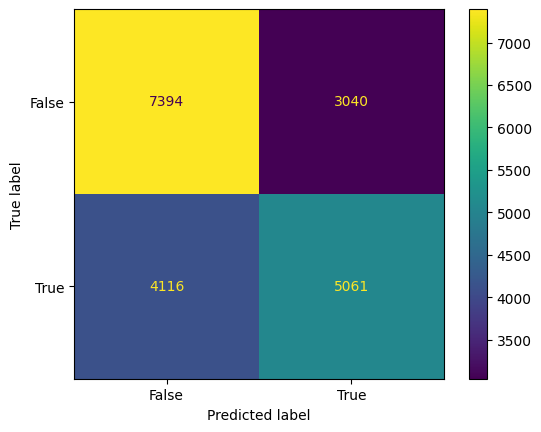

In [33]:
med_k = pipeline.get_params()["preproc__med__n_clusters"]
io_k = pipeline.get_params()["preproc__io__n_clusters"]
diag_k = pipeline.get_params()["preproc__diag__n_clusters"]
pca_n = len(num_features)
print(f"medication clusters = {med_k}")
print(f"in/out clusters = {io_k}")
print(f"diagnosis clusters = {diag_k}")
print(f"pca components = {pca_n}")
print("demographic features = 7")
print(f"total features = {7 + med_k + io_k + diag_k + pca_n}")
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
p = precision_score(y_test, y_pred)
a = accuracy_score(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(f"precision = {np.round(p, 2)}, accuracy = {np.round(a, 2)}")
print("confusion matrix:")

This model was fit on only 39 columns of data (8 cluster distances each for medications, in/out variables, and diagnoses and 8 principal components, plus 7 demographic features). Despite being fit on a dataset with 2309 fewer columns, precision and accuracy are almost identical to the scores on the full-dimensional model. This is plausibly because many of the features in the full-dimensional model contributed very little useful information to the prediction task. For instance, there are more than 2000 columns listed in `diag_features`, and all of those columns are filled almost entirely with 0s. One might expect that projecting that scarce information into a lower-dimensional space would be expected to have almost no effect on model performance. For that matter, one might expect that deleting the sparse diagnosis information would have only a negligible effect. To test this hypothesis, we can set `preproc` to drop the columns in `diag_features`.

In [34]:
preproc.set_params(
    transformers = [
        ("demo", "passthrough", demo_features),
        ("num", pca_preproc, num_features),
        ("med", clust_preproc, med_features),
        ("io", clust_preproc, io_features),
        ("diag", "drop", diag_features)
    ]
)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
p = precision_score(y_test, y_pred)
a = accuracy_score(y_test, y_pred)
print(f"precision = {np.round(p, 2)}, accuracy = {np.round(a, 2)}")

precision = 0.63, accuracy = 0.64


As expected, precision and accuracy are almost identical in the model without `diag_features`. 

We can test the effect of different levels dimension reduction more rigorously using cross-validation. Since `med_features`, `io_features`, and `diag_features` are the largest subsets of features, we will start by experimenting with eliminating these features. In the following cell, we define `transformer_grid`, an array of tuples `t` for which `t[0]`, `t[1]`, and `t[2]` are each set to either `"drop"` or `clust_preproc`. These three entries of `t` determine whether `med_features`, `io_features`, and `diag_features` are dropped from the model or undergo cluster preprocessing. After preprocessing, the model will have 7 demographic features, 8 numerical features, and 8 cluster differences for each set among `med_features`, `io_features`, and `diag_features` that are not dropped. The number of features in the preprocessed training set for each `t` is stored in `t[3]`, and strings listing the features sets that are dropped are stored in `t[4]`.

In [35]:
transformer_grid = [
    (clust_preproc, clust_preproc, clust_preproc, 7 + 8 + 8*3, None),
    ("drop", clust_preproc, clust_preproc, 7 + 8 + 8*2, "med"),
    (clust_preproc, "drop", clust_preproc, 7 + 8 + 8*2, "io"),
    (clust_preproc, clust_preproc, "drop", 7 + 8 + 8*2, "diag"),
    ("drop", "drop", clust_preproc, 7 + 8 + 8, "med,io"),
    (clust_preproc, "drop", "drop", 7 + 8 + 8, "io,diag"),
    ("drop", clust_preproc, "drop", 7 + 8 + 8, "diag,med"),
    ("drop", "drop", "drop", 7 + 8 + 0, "med,io,diag")
]

For each tuple `t` in `transformer_grid`, we set `preproc` according to `t[0]`, `t[1]`, and `t[2]`. We then perform 5-fold cross-validation and report average precision along with the number of features in the preprocessed training set and feature groups that were dropped.

In [36]:
for t in transformer_grid:
    preproc.set_params(
        transformers = [
            ("demo", "passthrough", demo_features),
            ("num", pca_preproc, num_features),
            ("med", t[0], med_features),
            ("io", t[1], io_features),
            ("diag", t[2], diag_features),
        ]
    )
    cv = cross_validate(
        pipeline,
        X_train, 
        y_train, 
        cv = 5,
        scoring = make_scorer(precision_score)
    )
    p = cv["test_score"].mean()
    print(f"num features = {t[3]}, precision = {p}, dropped features = {t[4]}")

num features = 39, precision = 0.6138601974122585, dropped features = None
num features = 31, precision = 0.6159562380330228, dropped features = med
num features = 31, precision = 0.5986518188764132, dropped features = io
num features = 31, precision = 0.6144666720721632, dropped features = diag
num features = 23, precision = 0.5964685794312194, dropped features = med,io
num features = 23, precision = 0.5964389142072748, dropped features = io,diag
num features = 23, precision = 0.6113329173285913, dropped features = diag,med
num features = 15, precision = 0.5952517828920479, dropped features = med,io,diag


All the precision scores are between 0.59 and 0.62, so dropping the columns in `med_features`, `io_features`, and `diag_features` from the model does not seem to have a significant impact on model performance. This indicates that these features do not contain much information that is useful for prediction. We already suspected this because of the sparsity of these feature groups, but one interesting observation from cross-validation is that the lowest precision scores occured during cross-validation of exactly those models from which `io_features` had been dropped. This might indicate that, among all the feature groups that underwent clustering, the features in `io_features` have the most useful information, and we might consider investigating these features further in order to improve overall model precision.

Now we perform one final round of cross-validation, this time examining how precision is effected by the number of principal components of `num_features` kept during preprocessing. We start by resetting `preproc` to perform clustering on `med_features`, `io_features`, and `diag_features`. We set `preproc` to drop the columns in `num_features` and cross-validate on the resulting training set, and then we reset `preproc` to perform principal component analysis on the columns in `num_features` with between 1 and 8 principal components. The relationship between precision and the number of princial components is graphed below.

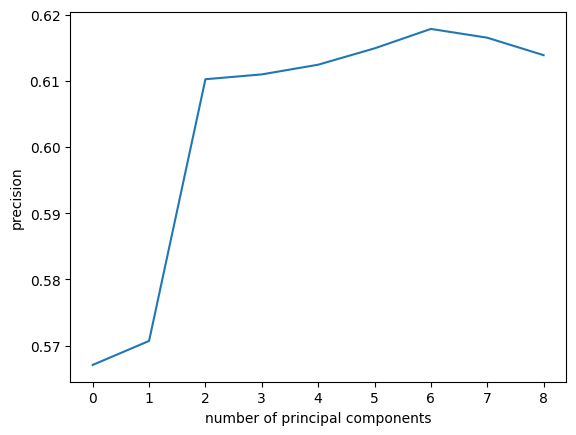

In [37]:
p_scores = []
preproc.set_params(
    transformers = [
        ("demo", "passthrough", demo_features),
        ("num", "drop", num_features),
        ("med", clust_preproc, med_features),
        ("io", clust_preproc, io_features),
        ("diag", clust_preproc, diag_features),
    ]
)
cv = cross_validate(
    pipeline,
    X_train, 
    y_train, 
    cv = 5,
    scoring = make_scorer(precision_score)
)
p_scores.append(cv["test_score"].mean())
preproc.set_params(
    transformers = [
        ("demo", "passthrough", demo_features),
        ("num", pca_preproc, num_features),
        ("med", clust_preproc, med_features),
        ("io", clust_preproc, io_features),
        ("diag", clust_preproc, diag_features),
    ]
)
for n in range(1,9):
    pipeline.set_params(preproc__num__pca__n_components = n)
    cv = cross_validate(
        pipeline,
        X_train, 
        y_train, 
        cv = 5,
        scoring = make_scorer(precision_score)
    )
    p_scores.append(cv["test_score"].mean())
plt.plot(list(range(9)), p_scores)
plt.xlabel("number of principal components")
plt.ylabel("precision")
plt.show()

Based on the cross-validation above, we can expect to get pretty good performance relative to the baseline model using a reduced model with only 17 features:

* 7 demographic features,
* 8 "in/out" cluster distances,
* 8 diagnosis features, and
* 6 principal components based on numerical information about hospital stays.

In the following cell, we set `preproc` to drop all the columns in `med_features` and `diag_features`, to perform clustering on the columns in `io_features`, and to keep only 2 principal components for the columns in `num_features`. We fit on the entire training set and predict on the test set. The model's performance metrics and a confusion matrix are shown below.

medication clusters = 8
in/out clusters = 8
diagnosis clusters = 0
pca components = 6
demographic features = 7
total features = 29
precision = 0.63, accuracy = 0.63
confusion matrix:


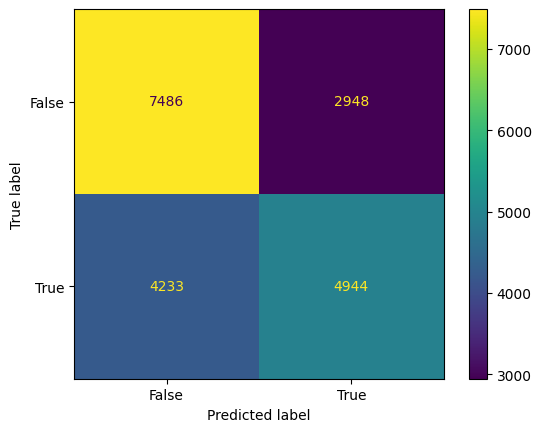

In [38]:
preproc.set_params(
    transformers = [
        ("demo", "passthrough", demo_features),
        ("num", pca_preproc, num_features),
        ("med", clust_preproc, med_features),
        ("io", clust_preproc, io_features),
        ("diag", "drop", diag_features),
    ]
)
pipeline.set_params(
    preproc__num__pca__n_components = 6
)
med_k = pipeline.get_params()["preproc__med__n_clusters"]
io_k = pipeline.get_params()["preproc__io__n_clusters"]
diag_k = 0
print(f"medication clusters = {med_k}")
print(f"in/out clusters = {io_k}")
print(f"diagnosis clusters = {diag_k}")
print("pca components = 6")
print("demographic features = 7")
print(f"total features = {7 + med_k + io_k + 6}")
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
p = precision_score(y_test, y_pred)
a = accuracy_score(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(f"precision = {np.round(p, 2)}, accuracy = {np.round(a, 2)}")
print("confusion matrix:")

# Discussion

The focus of this project was applying unsupervised learning techniques to perform dimension reduction on a dataset for a classification task related to hospital readmission among diabetes patients. We implemented a baseline supervised learner to perform classification on a dataset with 2347 features, and the model achieved a precision rate of 0.64 and an accuracy rate of 0.65. These are not particularly strong results, but rather than focusing on improving the performance of the supervised learner, we were interested in reducing the dimensionality of the underlying data as much as possible while maintaining precision and accuracy. The following table summarizes results for the baseline model and two of the models implemented with unsupervised techniques.

| Num. features | Precision | Accuracy |
|--------------:|----------:|---------:|
|          2347 |      0.64 |     0.65 |
|            39 |      0.63 |     0.64 |
|            29 |      0.63 |     0.63 |

Reducing the number of features in a data set by as much as 98.7% while maintaining 98.4% of the precision and 96.9% of the accuracy has obvious practical value. Most importantly, training and prediction by supervised learners on the reduced dataset is much more efficient. In this project, we implemented `XGBClassifier` specifically because of it is computationally efficient. Many supervised learners that handle high-dimensional data well are also computationally expensive. As a result, training and tuning these models might not be feasible in certain modeling situations without at least some dimesionality reduction. If unsupervised methods can reliably capture in a smaller number columns the most useful information in a dataset (as we saw in our models with unsupervised feature engineering), then the more computationally expensive methods become accessible in a wider range of modeling tasks.

Unsupervised learning can also shed insight into a dataset that is of theoretical interest. We consider possible insights from the hospital readmission data arising from the two unspervised learning techniques we used.

1. **Insights from PCA.** In principal component analysis, loadings indicate the weight of each original feature. A linear combination of original features weighted by loadings gives a new feature, and the axis of that new feature in the total feature space contains a known fraction of the variability observed in the data. Loadings are computed in descending order of the variability along their corresponding principal components' axes. This means that we can inspect the loadings to determine which variables seem to account for the most variation among the input features. A previous round of cross-validation indicated that two principal components contributed significantly to the precision of our model, so we might suspect that the features with the highest loadings in the first two components might have the most predictive power among all the features on which we performed principal component analysis. The cell below shows the loadings for the first two components. They indicate that `num_lab_procedures` and `num_medications` have the greatest weights in the first and second components. These features might be worth further investigation in a project aimed at increasing model precision and accuracy.

In [39]:
pca = PCA(n_components = 2)
pca.fit(df[num_features])
pc1 = pca.components_[0,:]
pc2 = pca.components_[1,:]
print("pc1 loadings\n============")
for feature, loading in zip(num_features, pc1):
    print(f"  feature = {feature}, loading = {np.round(loading, 2)}")
print("pc2 loadings\n============")
for feature, loading in zip(num_features, pc2):
    print(f"  feature = {feature}, loading = {np.round(loading, 2)}")

pc1 loadings
  feature = time_in_hospital, loading = 0.05
  feature = num_lab_procedures, loading = 0.99
  feature = num_procedures, loading = 0.01
  feature = num_medications, loading = 0.13
  feature = number_outpatient, loading = -0.0
  feature = number_emergency, loading = -0.0
  feature = number_inpatient, loading = 0.0
  feature = number_diagnoses, loading = 0.02
pc2 loadings
  feature = time_in_hospital, loading = 0.16
  feature = num_lab_procedures, loading = -0.14
  feature = num_procedures, loading = 0.09
  feature = num_medications, loading = 0.97
  feature = number_outpatient, loading = 0.01
  feature = number_emergency, loading = 0.0
  feature = number_inpatient, loading = 0.01
  feature = number_diagnoses, loading = 0.05


2. **Insights from $k$-means clustering.** We performed clustering on three subsets of features and compared model performance with the clustering to model performance with the clustering feature groups dropped completely. We observed that dropping the "in/out" features related to hospital admission and discharge seemed to have the strongest effect on prediction performance. These features, sparse though they are, seem to have more explanatory power the other feature groups to undergo clustering, and thus they are worth examining more closely. For example, the cell below shows hospital readmission rates for each `admission_type_id` code. Consider patients whose admissions were coded with the values 1 and 7. According to the documentation for the dataset, a value of 1 represents admission to the emergency room, and a value of 7 represents admission as a trauma patient. Evidently, being admitted to the hospital as an emergency room patient comes with a nearly 50% chance of being readmitted to the hopsital in the future, while being admitted as a trauma patient has almost no risk. Now consider patients admitted under code 6. This code turns out to be the code for NULL according to the dataset documentation, yet patients admitted under this code are more likely to be readmitted than patients admitted under any other code. There are probably explanations for the difference in readmission rates between patients admitted under codes 1 and 7 or for the high rate of readmission among patients admitted with a NULL code, and these explanations might help one to develop a more accurate classification model. Finding explanations will probably not rely exclusively on unsupervised machine learning, but if those explanations do lead to better models, it was unsupervised learning that suggested the "in/out" features as a place to look among the many combinations of features related to admission, discharge, medication, and diagnosis.

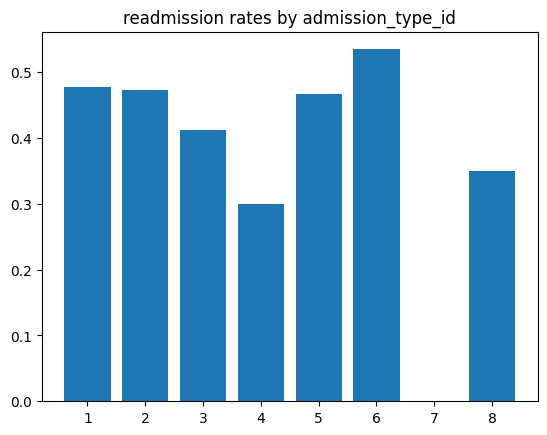

In [40]:
admit_ids = [f"admission_type_id_{str(i)}" for i in range(1,9)]
readmit_by_admit_id = [(
    df[df[i] == 1]["readmitted"] == 1
).mean() for i in admit_ids]
plt.bar(range(1,9), readmit_by_admit_id)
plt.title("readmission rates by admission_type_id")
plt.show()


To be sure, our model still needs a lot of improvement before it can usefully predict readmission in real hospitals. However, our modeling process indicates a possible pathway for future development. Principal component analysis and $k$-means clustering can effectively reduce the dimensionallity of complicated medical data, enabling the use of sophisticated machine learning techniques that tend to be computationally expensive in high dimensions. The same unsupervised techniques can also highlight subtle relationships in the data that can be leveraged to create models with more predictive power.